In [6]:
%matplotlib inline
import sys
import os
import csv

import pickle
import copy
import ase.io
import numpy as np
import torch

from amptorch.trainer import AtomsTrainer
from numpy.random import default_rng

from pykdtree.kdtree import KDTree
from sklearn.preprocessing import StandardScaler

from scipy.stats import gaussian_kde
import matplotlib
from matplotlib import pyplot as plt
import copy
from ase.calculators.singlepoint import SinglePointCalculator
import time
import hashlib
import seaborn as sns

def load_training_data(training_filename, test_filename):

    training_list = ase.io.read(training_filename, index=":")
    test_list = ase.io.read(test_filename, index=":")

    return training_list, test_list

def write2csv(csv_filename, message, header=None):
    if os.path.exists(csv_filename) is False:
        if header is not None:
            with open(csv_filename, "w", newline="") as f:
                writer = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
                writer.writerow(header)

    with open(csv_filename, "a", newline="") as f:
        writer = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(message)
    return

def calc_dist(train_X, calib_X, nearest_neighbors=10, metric="minkowski"):
    std_scaler = StandardScaler().fit(train_X)
    train_X_std_scaled = std_scaler.transform(train_X)
    calib_X_std_scaled = std_scaler.transform(calib_X)
    
    kdtree = KDTree(train_X_std_scaled)
    dist, ind = kdtree.query(calib_X_std_scaled, k=nearest_neighbors)
    
    return dist.mean(axis=1)

def predict_data(pred_energies, test_images):    
    true_energies = np.array([image.get_potential_energy() for image in test_images])

    list_of_error_per_atom = []

    for i, image in enumerate(test_images):
        num_atoms = len(image.get_atomic_numbers())
        # total_energy_pred = pred_energies[i]
        # total_energy_true = true_energies[i]

        error = pred_energies[i] - true_energies[i]
        per_atom_error = error / num_atoms
        list_of_error_per_atom.append(per_atom_error)

    return list_of_error_per_atom

class ConformalPrediction():
    def __init__(self, residuals_calib, heurestic_uncertainty_calib, alpha) -> None:
        # score function
        scores = abs(residuals_calib / heurestic_uncertainty_calib)
        scores = np.array(scores)

        n=len(residuals_calib)
        qhat = torch.quantile(torch.from_numpy(scores), np.ceil((n + 1) * (1 - alpha)) / n)
        qhat_value = np.float64(qhat.numpy())
        self.qhat = qhat_value
        pass

    def predict(self, heurestic_uncertainty_test):
        return heurestic_uncertainty_test * self.qhat, self.qhat


def split_test_calib(full_test_X, full_test_y, per_calib, seed=0):
    # sub-select calib and test
    np.random.seed(seed)

    # num_total=5000
    num_total = len(full_test_X)

    num_calib = round(per_calib * num_total)

    rand_idx = np.random.choice(num_total, size=num_total, replace=False)
    calib_idx = rand_idx[:num_calib]
    test_idx = rand_idx[num_calib::]

    calib_X = [full_test_X[_] for _ in calib_idx]
    test_X = [full_test_X[_] for _ in test_idx]

    calib_y = [full_test_y[_] for _ in calib_idx]
    test_y = [full_test_y[_] for _ in test_idx]

    return test_X, test_y, calib_X, calib_y


def prepare_latentNerror_from_trainer(trainer, images, image_type, get_latent=-2):
    predictions = trainer.predict(images, get_latent=get_latent)
    latent = np.array(predictions["latent"])

    # errors for train, test, calib
    if image_type in ["test", "calib", "train"]:
        y_bar = np.array(predictions["energy"])
        list_error = predict_data(y_bar, images)
        list_error = np.array(list_error)
    else:
        raise NotImplementedError  

    return latent, list_error

def calc_uncertainty_metrics(list_epa, uncertainty):
    overconfident_idx = np.argwhere(abs(list_epa) > uncertainty)

    prob_overconfidence = len(overconfident_idx) / len(uncertainty)
    avg_uncertainty = np.mean(uncertainty)
    
    return prob_overconfidence, avg_uncertainty

def get_result_hash(parameter_string):
    string = str(parameter_string)
    md5 = hashlib.md5(string.encode("utf-8"))
    hash_result = md5.hexdigest()
    return hash_result


In [2]:
trial = 50000
nn_struct = 32
get_latent= -2
per_calib=0.1
seed=1
num_nearest_neighbors=10
metric = "minkowski"

path2config = <input checkpoint dir> # checkpoint dir by training

In [3]:
# plot setting
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
colors=["#f14432", "#fc8a6a"]

matplotlib.rcParams.update(matplotlib.rcParamsDefault)


# Set figure defaults
width = 6.5 / 3
fontsize = 10
rc = {'figure.figsize': (width, width),
#       'font.family': "serif",
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': 'small',
      'ytick.labelsize': 'small',
      'legend.fontsize': fontsize}

matplotlib.rcParams.update(rc)

In [4]:
# load train and test data

train_filename = <input train dataset dir>
test_filename = <input test dataset dir>

# load test and train ds
train_list, test_list = load_training_data(train_filename, test_filename)

In [7]:
# predict training dataset

parameter_string = str([path2config, test_filename, train_filename])
analysis_hash = get_result_hash(parameter_string)
if not os.path.exists("trial_{}/{}".format(trial, analysis_hash)):
    os.mkdir("trial_{}/{}".format(trial, analysis_hash))

full_train_X_filename = "trial_{}/{}/full_train_X_{}.p".format(trial, analysis_hash, nn_struct)
full_train_y_filename = "trial_{}/{}/full_train_y_{}.p".format(trial, analysis_hash, nn_struct)
full_test_X_filename = "trial_{}/{}/full_test_X_{}.p".format(trial, analysis_hash, nn_struct)
full_test_y_filename = "trial_{}/{}/full_test_y_{}.p".format(trial, analysis_hash, nn_struct)
t_latent_prep_filename = "trial_{}/{}/t_latent_prep_{}.p".format(trial, analysis_hash, nn_struct)

if not os.path.exists(full_test_y_filename):
    print("Calculating latent representation...")
    t0 = time.time()
    trainer = AtomsTrainer()
    trainer.load_pretrained(path2config)

    train_X, train_y = prepare_latentNerror_from_trainer(trainer, train_list, "train", get_latent=get_latent)
    full_test_X, full_test_y = prepare_latentNerror_from_trainer(trainer, test_list, "train", get_latent=get_latent)

    # counting the time to calculate latent
    t_latent_prep = time.time() - t0

    # save the latent space features and energies
    pickle.dump(train_X, open(full_train_X_filename, "wb"))
    pickle.dump(train_y, open(full_train_y_filename, "wb"))
    pickle.dump(full_test_X, open(full_test_X_filename, "wb"))
    pickle.dump(full_test_y, open(full_test_y_filename, "wb"))
    pickle.dump(t_latent_prep, open(t_latent_prep_filename, "wb"))
else:
    # load
    print("Loading latent representation...")
    train_X = pickle.load(open(full_train_X_filename, "rb"))
    train_y = pickle.load(open(full_train_y_filename, "rb"))
    full_test_X = pickle.load(open(full_test_X_filename, "rb"))
    full_test_y = pickle.load(open(full_test_y_filename, "rb"))    
    t_latent_prep = pickle.load(open(t_latent_prep_filename, "rb"))
    pass

Calculating latent representation...
Loading checkpoint from ./checkpoints/2022-02-03-17-52-17-data50000-ordernorm_sigma10logwide_MCSH3_NN32_constrs1.0_sh1
Use Xavier initialization
Loading model: 11393 parameters
Loading skorch trainer
latent layer -2
latent layer -2


In [8]:
from scipy import stats
from scipy.optimize import minimize

# predict test and calib
test_X, test_y, calib_X, calib_y = split_test_calib(full_test_X, full_test_y, per_calib, seed=seed)
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
calib_X = np.array(calib_X)
calib_y = np.array(calib_y)

# convert energy from kcal/mol to meV/sys
train_y *= 0.04336 * 1000
test_y *= 0.04336 * 1000
calib_y *= 0.04336 * 1000

# calculating the distance metric for test+calib
t0 = time.time()
calib_dist = calc_dist(train_X, calib_X, nearest_neighbors=num_nearest_neighbors, metric=metric)
test_dist = calc_dist(train_X, test_X, nearest_neighbors=num_nearest_neighbors, metric=metric)
t_dist = time.time() - t0

colors=["#f14432", "#fc8a6a"]

def gaussian(params):
    s1 = params[0]   
    s2 = params[1]

    # Calculate negative log likelihood
    nll = -np.sum(stats.norm.logpdf(calib_y, loc=0, scale=s1 + calib_dist * s2))

    return nll

initParams = [5e-8, 4]

results = minimize(gaussian, initParams, method='Nelder-Mead')

s1 = results.x[0]
s2 = results.x[1]

test_std = s1 + test_dist * s2
t_nll = time.time() - t0

print("t_dist = {:.2f}".format(t_dist))
print("t_nll = {:.2f}".format(t_nll))

t_dist = 73.61
t_nll = 73.63


In [9]:
def get_p_one_two_outsideTwo(test_sub_epa, test_latent_std):
    # one std
    len_one_std = np.where(np.abs(test_sub_epa) < np.abs(test_latent_std))[0]
    len_one_std = len(len_one_std)
    p_one_std = len_one_std / len(test_sub_epa)
    
    # two stds
    len_two_std = np.where(np.abs(test_sub_epa) < 2 * np.abs(test_latent_std))[0]
    len_two_std = len(len_two_std)
    p_two_std = len_two_std / len(test_sub_epa)

    # outside two stds
    p_overconfidence = 1 - p_two_std
    
    return (p_one_std, p_two_std, p_overconfidence)

In [10]:
import matplotlib.patheffects as PathEffects

def plot_scatter_residuals_vs_heurestic_uncertainty(latent_std_test, residuals_test, xlabel="latent std. [meV/sys]", title=None, save_filename=None,dpi=None):
    latent_std_test = copy.deepcopy(latent_std_test)
    residuals_test = copy.deepcopy(residuals_test)
    ref_fx = np.linspace(np.amin(latent_std_test), np.amax(latent_std_test), 100)
    xy = np.vstack([latent_std_test, residuals_test])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    latent_std_test, residuals_test, z = latent_std_test[idx], residuals_test[idx], z[idx]

    ax.plot(ref_fx, ref_fx,c=colors[0])
    ax.plot(ref_fx, - ref_fx,c=colors[0])

    ax.plot(ref_fx, 2 * ref_fx,c=colors[1])
    ax.plot(ref_fx, - 2 * ref_fx,c=colors[1])

    ax.fill_between(ref_fx, ref_fx, -ref_fx, alpha=0.2, color=colors[0], linewidth=0)
    ax.fill_between(ref_fx, 2 * ref_fx, - 2 * ref_fx, alpha=0.2, color=colors[1], linewidth=0)
    ax.plot(ref_fx, [0]*100, "--", color="darkgray")

    x_lower_lim = np.quantile(latent_std_test, 1e-4)
    x_upper_lim = np.quantile(latent_std_test, 0.998)
    
    # force share-y
    ax.set_xlim([x_lower_lim, x_upper_lim])
    ax.set_ylim([-7.5, 7.5])
    
    
    # add text of prob
    prob_posi = (x_upper_lim - x_lower_lim) * .8 + x_lower_lim
    p_1, p_2, p_3 = get_p_one_two_outsideTwo(residuals_test, latent_std_test)
    txt = ax.text(prob_posi, 0.7, "{:.0f}%".format(p_1*100), color=colors[0])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(prob_posi, 3.3, "{:.0f}%".format(p_2*100), color=colors[1])
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])
    txt = ax.text(prob_posi, 6.0, "{:.0f}%".format(p_3*100), color="k")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])

    pcm = ax.scatter(latent_std_test, residuals_test, c=z, s=20, linewidths=None, alpha=.2)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel("residual [meV/sys]")


    if title is not None:
        ax.set_title(title)

    return fig, ax

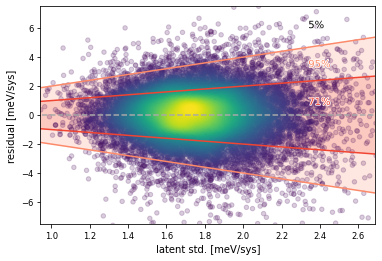

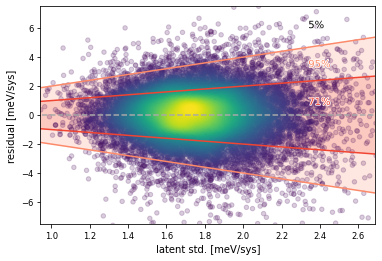

In [11]:

fig_filename = "./figures/panel_method_comparison/nll_latent_std_dpi300.png"

fig, ax = plt.subplots()
fig, ax = plot_scatter_residuals_vs_heurestic_uncertainty(test_std, test_y)
# fig.savefig(fig_filename, dpi=300, bbox_inches="tight", transparent=True)
fig

In [12]:
# analyze which the portion of test data in between one to two std

from scipy.stats import norm

# count the number of instances

expected_stds = np.linspace(norm.ppf(1e-4),
                norm.ppf(1-1e-4), 15)

# normalize 
test_std, test_avg = test_std, test_y 
test_avg_norm = test_avg / test_std

expected_ps = []
observed_ps = []

for std in expected_stds: 
    count = np.sum(test_avg_norm < std)
    observed_ps.append(count / len(test_avg_norm))
    expected_ps.append(norm.cdf(std))

In [13]:
# calculate the area of miscalculation in calibration curve

from scipy.integrate import trapz as trapezoid

area = 0

for i in range(1, len(observed_ps)+1):
    trap = np.abs(trapezoid(observed_ps[i-1:i+1], expected_ps[i-1:i+1]) 
                  - trapezoid(expected_ps[i-1:i+1], expected_ps[i-1:i+1]))
    area += trap

area

0.010049753287871159

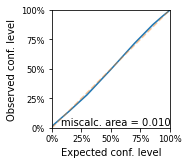

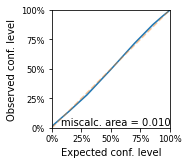

In [14]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(width, width))
expected_ps = np.array(expected_ps) * 100 # convert to %
observed_ps = np.array(observed_ps) * 100 # convert to %

ax.plot(expected_ps, observed_ps)
ax.plot(expected_ps, expected_ps, "--", alpha=0.4)

ax.fill_between(expected_ps, expected_ps, observed_ps, alpha=0.2, linewidth=0)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_aspect('equal')

ax.set_xlabel("Expected conf. level")
ax.set_ylabel("Observed conf. level")
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.text(8, 2, "miscalc. area = {:.3f}".format(area))

save_filename = "./figures/panel_method_comparison/nll_latent_calibration_curve.pdf"
# fig.savefig(save_filename,bbox_inches='tight', transparent=True)
fig

In [ ]:
np.mean(test_std)